In [9]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys

# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [10]:
path = '/Users/bavi_tesh/Documents/GitHub/PatternRecognition/Assignments/HW 3/lfw'

In [11]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [12]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")

torch.Size([250, 250, 3])


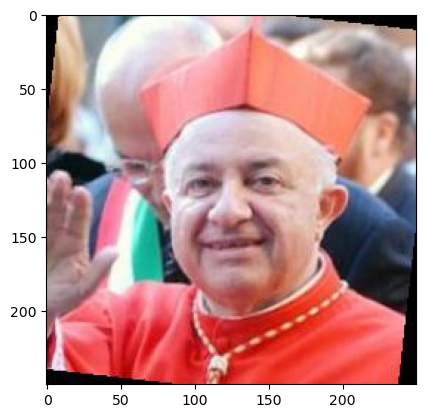

In [13]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [14]:
batch = next(iter(dataloader))
images = batch[0]  # Access the images from the batch
labels = batch[1]  # Access the labels from the batch

# Select a specific image from the batch
image_sample = images[30]
print(f"Sample image dimensions: {image_sample.shape}")

Sample image dimensions: torch.Size([3, 250, 250])


The dimensions `[3, 250, 250]` represent a batch of 3 RGB images. The first dimension is the batch size, the second is the number of color channels (RGB), and the last two are the height and width of each image, respectively. The size of 250 in both height and width indicates that each image is 250 pixels by 250 pixels.

# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [15]:
import torch
import torch.nn as nn

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        # Define the encoder layers
        self.enc_conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.enc_bn1 = nn.BatchNorm2d(32)
        self.enc_conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.enc_bn2 = nn.BatchNorm2d(64)
        self.enc_conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.enc_bn3 = nn.BatchNorm2d(128)

        # Define the decoder layers with output shape [250, 250, 3]
        self.dec_conv1 = nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.dec_bn1 = nn.BatchNorm2d(64)
        self.dec_conv2 = nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.dec_bn2 = nn.BatchNorm2d(32)
        self.dec_conv3 = nn.ConvTranspose2d(32, 3, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.dec_bn3 = nn.BatchNorm2d(3)

        # Upsampling layer to achieve the desired output size
        self.upsample = nn.Upsample(size=(250, 250), mode='bilinear', align_corners=True)

    def encoder(self, x):
        x = nn.functional.relu(self.enc_bn1(self.enc_conv1(x)))
        x = nn.functional.relu(self.enc_bn2(self.enc_conv2(x)))
        x = nn.functional.relu(self.enc_bn3(self.enc_conv3(x)))
        return x

    def decoder(self, x):
        x = nn.functional.relu(self.dec_bn1(self.dec_conv1(x)))
        x = nn.functional.relu(self.dec_bn2(self.dec_conv2(x)))
        x = torch.sigmoid(self.dec_bn3(self.dec_conv3(x)))
        x = self.upsample(x)
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [16]:
autoencoder = AE()

# Create a dummy input image (example size: 1x3x256x256, batch_size x channels x height x width)
# Replace this with your actual image tensor
input_image = torch.randn(1, 3, 250, 250)

# Forward the input image through the autoencoder
with torch.no_grad():
    encoded_output = autoencoder.encoder(input_image)
    decoded_output = autoencoder.decoder(encoded_output)

    # Print the shapes
    print(f"Shape of the encoder output: {encoded_output.shape}")
    print(f"Shape of the decoder output: {decoded_output.shape}")

# Ensure the model is in evaluation mode
autoencoder.eval()


Shape of the encoder output: torch.Size([1, 128, 32, 32])
Shape of the decoder output: torch.Size([1, 3, 250, 250])


AE(
  (enc_conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (enc_bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc_conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (enc_bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc_conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (enc_bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dec_conv1): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
  (dec_bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dec_conv2): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
  (dec_bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dec_conv3): ConvTranspose2d(32, 3, kernel_size=(5, 5), st

##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [25]:
total_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)

print(f"Total number of trainable parameters in the model: {total_params}")

loss_function=nn.MSELoss();

learning_rate = 0.001
optim = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)

Total number of trainable parameters in the model: 352393


For image reconstruction tasks in autoencoders, the Mean Squared Error (MSE) loss is standard, quantifying the average squared difference between input and reconstructed output. The Adam optimizer is commonly chosen for training neural networks, including autoencoders, due to its adaptive learning rate capabilities. To instantiate the optimizer adjusting the learning rate, here set to 0.001, based on model performance.

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [41]:
num_epochs = 8
learning_rate = 0.001
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)
loss_function = nn.MSELoss()

# Move your model to the desired device
model = autoencoder.to(device)

for epoch in range(num_epochs):
    total_loss = 0.0

    for data in dataloader:
        imgs, _ = data
        imgs = imgs.to(torch.float32).to(device)

        optimizer.zero_grad()

        outputs = model(imgs)
        loss = loss_function(outputs, imgs)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/8], Loss: 0.0025
Epoch [2/8], Loss: 0.0022
Epoch [3/8], Loss: 0.0022
Epoch [4/8], Loss: 0.0022
Epoch [5/8], Loss: 0.0021
Epoch [6/8], Loss: 0.0021
Epoch [7/8], Loss: 0.0021
Epoch [8/8], Loss: 0.0021


If the loss during training is not decreasing, it indicates potential issues in the training process. To troubleshoot this, one should follow. Firstly, experiment with different learning rates, as an inappropriate rate might hinder convergence. Adjust the model complexity by modifying its architecture, adding or removing layers, or trying alternative configurations. Verify that the selected loss function is appropriate for the task at hand. Implement the Adam optimizer, known for its versatility, by fine-tuning the learning rate based on observed model performance. Iteratively applying these troubleshooting steps, along with monitoring metrics and adapting hyperparameters accordingly, can help diagnose and address the factors contributing to the lack of loss reduction during training.

##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

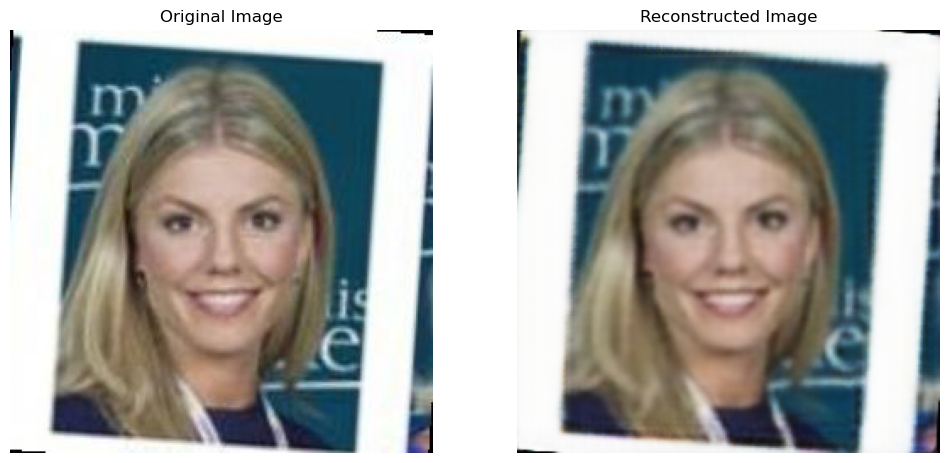

In [42]:

# Get a batch of data from the DataLoader
dataiter = iter(dataloader)
images, _ = next(dataiter)
images = images.to(device)

# Choose a random index from the batch
random_index = random.randint(0, images.size(0) - 1)
random_image = images[random_index].unsqueeze(0)

# Forward pass through the autoencoder
with torch.no_grad():
    reconstructed_image = autoencoder(random_image)

# Convert tensors to numpy arrays for plotting
original_image_np = random_image.squeeze().permute(1, 2, 0).cpu().numpy()
reconstructed_image_np = reconstructed_image.squeeze().permute(1, 2, 0).cpu().numpy()

# Plot the original and reconstructed images side by side
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(original_image_np)
plt.title('Original Image')
plt.axis('off')

# Reconstructed Image
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image_np)
plt.title('Reconstructed Image')
plt.axis('off')

plt.show()


##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

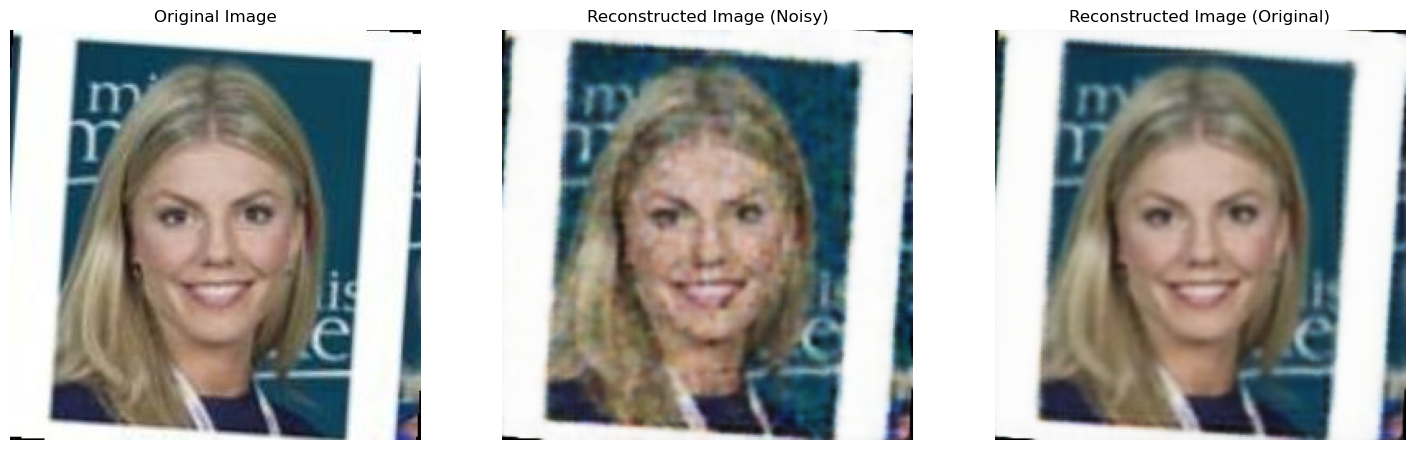

In [44]:

# Forward pass through the autoencoder
with torch.no_grad():
    # Encode the original image
    encoded_image = autoencoder.encoder(random_image)

    # Add small normally distributed noise to the latent representation
    noise = torch.randn_like(encoded_image) * 0.1  # Adjust the standard deviation as needed
    noisy_encoded_image = encoded_image + noise

    # Decode the noisy latent representation
    reconstructed_image_noisy = autoencoder.decoder(noisy_encoded_image)

# Convert tensors to numpy arrays for plotting
original_image_np = random_image.squeeze().permute(1, 2, 0).cpu().numpy()
reconstructed_image_noisy_np = reconstructed_image_noisy.squeeze().permute(1, 2, 0).cpu().numpy()

# Plot the original and reconstructed (noisy) images side by side
plt.figure(figsize=(18, 6))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(original_image_np)
plt.title('Original Image')
plt.axis('off')

# Reconstructed Image (Noisy)
plt.subplot(1, 3, 2)
plt.imshow(reconstructed_image_noisy_np)
plt.title('Reconstructed Image (Noisy)')
plt.axis('off')

# Reconstructed Image (Original)
plt.subplot(1, 3, 3)
plt.imshow(reconstructed_image_np)
plt.title('Reconstructed Image (Original)')
plt.axis('off')

plt.show()


Adding noise during autoencoder training acts as regularization, improving generalization and preventing overfitting. It enhances denoising capabilities, making the model robust to variations. The latent space structure is influenced, mapping similar clean images to nearby points. Training dynamics may change, requiring careful tuning of noise levels. Decoded images might exhibit smoother appearance and reduced sensitivity to details. Overall, noise aids in learning robust features and improving the autoencoder's ability to handle real-world variations in data.